# Predicción de la producción de energía éolica con SKlearn.

Este código pertenece a la primera práctica de la asignutra de Aprendizaje Automático.

100471948 - Celia Patricio Ferrer

100472039 - Alberto García de la Torre

### Librerías necesarias.

In [38]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Modelos
from sklearn import tree
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lineartree import LinearTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, Normalizer, QuantileTransformer

# HPO
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from scipy.stats import randint as sp_randint

---
## Lectura del archivo.
---

En primer lugar se lee el archivo que contiene los datos disponibles. Es decir, se realiza la lectura del archivo csv llamado *wind_ava.csv.gz*.

In [39]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")

# Imprimir el dataframe.
print(wind_ava)

                 datetime   energy     p54.162.1     p54.162.2     p54.162.3  \
0     2005-01-02 18:00:00   402.71  2.534970e+06  2.526864e+06  2.518754e+06   
1     2005-01-03 00:00:00   696.80  2.537369e+06  2.529277e+06  2.521184e+06   
2     2005-01-03 06:00:00  1591.15  2.533727e+06  2.525703e+06  2.517678e+06   
3     2005-01-03 12:00:00  1338.62  2.534491e+06  2.526548e+06  2.518609e+06   
4     2005-01-03 18:00:00   562.50  2.529543e+06  2.521623e+06  2.513702e+06   
...                   ...      ...           ...           ...           ...   
4743  2009-12-30 06:00:00  1280.13  2.407224e+06  2.400131e+06  2.393033e+06   
4744  2009-12-30 12:00:00   855.00  2.407234e+06  2.400117e+06  2.393001e+06   
4745  2009-12-30 18:00:00   117.06  2.401034e+06  2.393683e+06  2.386332e+06   
4746  2009-12-31 12:00:00   516.96  2.393873e+06  2.386499e+06  2.379125e+06   
4747  2009-12-31 18:00:00   867.07  2.392305e+06  2.384669e+06  2.377033e+06   

         p54.162.4     p54.162.5     p5

Como podemos ver, este dataset está formado por 4748 instancias y 552 atributos.

---
## Filtrado de datos.
---

Se deben quitar las variables metereológicas que no correspondan a la localización de Sotavento, la localización 13.

Estas variables serán las **variables de entrada** de nuestro problema.

In [40]:
X_df = wind_ava.filter(regex='.13$')
# Imprimir el dataframe.
print(X_df)

        p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0     2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1     2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2     2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3     2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4     2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   
...            ...         ...        ...           ...        ...        ...   
4743  2.385772e+06   14.413342  24.971074  3.905586e+06   2.349839   2.434994   
4744  2.385708e+06   12.802883  60.248874  2.745694e+06   2.349446   2.434849   
4745  2.379049e+06   10.915997   3.145067  2.254171e+06   2.349054   2.434715   
4746  2.371697e+06   13.048144  12.580268  1.376913e+06   2.347799   2.434291   
4747  2.369547e+06    9.172745   8.487892  1.356687e+06   2.347406   2.434145   

       u10n.13   v10n.13   

In [ ]:
# Imprimir el tamaño del dataframe.
print(X_df.shape)

In [ ]:
# Imprimir las primeras filas del dataframe.
print(X_df.head())

In [ ]:
# Imprimir el tipo de atributos.
X_df.info()

Para determinar si el problema es de regresión o de clasificación. 

- Si se trata de un problema de clasificación o de regresión (variable de salida es una clase o un valor continuo), y en caso de clasificación, si la clase está desequilibrada.

En nuestro caso, la **varible de salida** es *energy*.

In [41]:
# Imprimir los primeros valores la variable de salida.
y_df = wind_ava['energy']
print(y_df.head())

0     402.71
1     696.80
2    1591.15
3    1338.62
4     562.50
Name: energy, dtype: float64


Obtenemos que son valores númericos de salida, lo que significa que se trata de un **problema de reglesión**.

---
## Análisis Exploratorio de Datos Simplificado.
---

### Variables.

Identificar qué varibles son categóricas y qué variables son numéricas.

In [42]:
categoricas = X_df.select_dtypes(include=['object']).columns
numericas = X_df.select_dtypes(exclude=['object']).columns

# Imprimir por pantalla dicho resultado.
print("Variables categóricas:", categoricas)
print("Variables numéricas:", numericas)

Variables categóricas: Index([], dtype='object')
Variables numéricas: Index(['p54.162.13', 'p55.162.13', 'cape.13', 'p59.162.13', 'lai_lv.13',
       'lai_hv.13', 'u10n.13', 'v10n.13', 'sp.13', 'stl1.13', 'u10.13',
       'v10.13', 't2m.13', 'stl2.13', 'stl3.13', 'iews.13', 'inss.13',
       'stl4.13', 'fsr.13', 'flsr.13', 'u100.13', 'v100.13'],
      dtype='object')


Obtenemos que todas las variables son numéricas, es decir, son características o atributos numéricos.

Análisis completo de cada variable.

In [ ]:
resultados = []

for variable in X_df.columns:
    summary = X_df[variable].describe()
    mean = summary['mean']
    std_dev = summary['std']
    variance = std_dev**2
    resultados.append([variable, mean, std_dev, variance])

# Convertir la lista de listas en un DataFrame y mostrarlo
df_resultados = pd.DataFrame(resultados, columns=["Variable", "Media", "Desviación típica", "Varianza"]).sort_values(by="Varianza", ascending=True)
pd.set_option('display.max_colwidth', None)
display(df_resultados)


Con el cálculo de la relación Varianza/Media, identificamos la dispersión relativa que hay de los datos en relación con su valor promedio. Tras analizar uno por uno todos los valores, hemos considerado que las siguientes variables tenían una relación muy baja:
- fsr.13
- flsr.13
- lai_hv.13
- iews.13
- inss.13
- lai_lv.13

### Número de características e instancias.

In [ ]:
# Imprimir la cantidad de característica e instancias del dataframe.
print("Nº de características: ", X_df.shape[1])
print("Nº de instancias: ", X_df.shape[0])

Es decir, el dataset está formado por 4748 instancias y 22 atributos o características.

### Valores faltantes.

En esta sección se especifica si hay valores faltantes (*missing values*) y qué variables los tienen.

In [ ]:
# Imprimir la cantidad de valores faltantes por variable.
print(X_df.isnull().sum())

Como podemos ver, no hay ninguna variable con valores faltantes.

### Columnas constantes.

Evualuación de columnas constantes y en caso de haberlas, eliminarlas.

In [ ]:
columnas_constantes = X_df.columns[X_df.nunique() == 1]
X_df = X_df.drop(columnas_constantes, axis=1)
print("Columnas constantes eliminadas:", columnas_constantes)

Como podemos ver, no hay columnas constantes. Sin embargo, como hemos calculado anteriormente, hay algunas columnas con varianza muy pequeña, las tendremos en cuenta posteriormente.

### Correlación de variables

En esta sección, analizaremos la correlación que pueda existir entre las variables, incluyendo la variable de salida. Esto lo realizaremos a través de la matriz de correlación. Y destacaremos aquellas variables con una alta correlación para tenerlas en cuenta posteriormente.

In [ ]:
# Creamos la matriz de correlación
plt.figure(figsize=(20, 15))
df = X_df.copy()
df.insert(0, 'energy', wind_ava['energy'])
correlation_matrix = df.corr()
sns.heatmap(data=correlation_matrix, annot=True)

En cuanto a la correlación negativa, ningún par de variables presentan dicha correlación, ya que ninguna rebaja el -0.4. Sin embargo, hay algunos pares de variables que muestran una alta correlación positiva. Y estos son los siguientes:
- u10 - u10n
- v10 - v10n
- lai_lv - lai_hv
- u10n - iews
- u100 - iews
- v100 - inss
- stl2 - stl3
- u100 - u10
- v100 - v10
- u100 - u10n
- v100 - v10n
- flsr - fsr
- lai_lv - stl2
- lai_hv - stl2

Mientras que entre las variables de entrada con la variable de salida (*energy*), no se aprecia una alta correlación.

Con las siguientes gráficas verificamos visualmente la correlación entre las variables de entrada. Para ello, veremos dibujadas la relación que existe entre la variable v10 y en función de la variable v10n. 

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(wind_ava['v10.13'], wind_ava["v10n.13"], color='skyblue', marker='o', s=10)
plt.title('Histograma de la correlación entre v10 y v10n', size=20)
plt.xlabel('Valor de v10', size=14)
plt.ylabel('Valor de v10n', size=14)
plt.grid(True)
plt.show()

Como podemos ver, esta gráfica nos confirma que tienen una alta relación positiva, a medida que una crece, la otra también lo hace.

### Distribución de la variable de salida.

A continuación, vamos a analizar la distribución de la variable de salida, llamada *energy*.

In [ ]:
# Dibujamos el histograma de la variable de salida
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.histplot(y_df, bins=30, color='purple', kde=True, edgecolor='black')
plt.title('Histograma de la variable energy', size=25)
plt.show()

Obtenemes que la distribución de esta variable es exponencial, podemos apreciar una alta frecuencia de valores de baja energía.

---
## Evaluación outer.
---

En primer lugar, realizaremos la evaluación de diferentes modelos de regresión con sus hiperparámetros por defecto. 

Al tratarse de un problema de regresión, las métricas que se utilizarán para evaluar el rendimiento de cada modelo serán: RMSE (Error Cuadrático Medio) y R2 (Coeficiente de Determinación). Además dividiremos el conjunto de datos entre entrenamiento y test de esta forma: 2/3 y 1/3, respectivamente.

In [43]:
# Dividimos los datos entre entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=49)

### KNN.

En primer lugar, crearemos un modelo KNN sin escalar los datos y evaluaremos el rendimiento obtenido.

In [44]:
# Creamos el modelo.
regr_knn = KNeighborsRegressor()
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn_o = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test)
# Evaluamos el rendimiento del modelo.
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")

RMSE: 636.3288087730467
R2: 0.06026198644919867


A continuación, escalaremos los datos aplicando diferentes métodos y evaluaremos cuál es el de mejor y más apropiado para este problema. 

- *StandardScaler*: escala los datos para que tengan una media de 0 y una desviación estándar de 1.

- *MinMaxScaler*: escala los datos al intervalo especificado (por defecto [0, 1]).

- *RobustScaler*: escala los datos utilizando estadísticas robustas para manejar valores atípicos.

- *MaxAbsScaler*: escala los datos dividiendo cada característica por su valor máximo absoluto.

- *QuantileTransformer*: transforma los datos para que tengan una distribución uniforme o gaussiana.

In [45]:
def escalado(scaler):
    model = KNeighborsRegressor()
    X_train_result = scaler.fit_transform(X_train)
    X_test_result = scaler.transform(X_test)
    # Entrenamos el modelo.
    inicio = time.time()
    model.fit(X_train_result, y_train)
    fin = time.time()
    tiempo = fin - inicio
    # Realizamos las predicciones.
    y_test_pred = model.predict(X_test_result)
    # Evaluamos el rendimiento del modelo.
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    r2 = metrics.r2_score(y_test, y_test_pred)
    return rmse, r2, tiempo

In [46]:
# StandardScaler
scaler = StandardScaler()
rmse_standar, r2_standar, t_standar = escalado(scaler)
# MinMaxScaler
scaler = MinMaxScaler()
rmse_minmax, r2_minmax, t_minmax = escalado(scaler)
# RobustScaler
scaler = RobustScaler()
rmse_robust, r2_robust, t_robust = escalado(scaler)
# MaxAbsScaler
scaler = MaxAbsScaler()
rmse_maxabs, r2_maxabs, t_maxabs = escalado(scaler)
# QuantileTransformer
scaler = QuantileTransformer()
rmse_quantile, r2_quantile, t_quantile = escalado(scaler)

In [47]:
# Imprimimos en un dataframe todos los resultados.
resultados = pd.DataFrame({
    "RMSE": [rmse_knn, rmse_standar, rmse_minmax, rmse_robust, rmse_maxabs, rmse_quantile],
    "R2": [r2_knn, r2_standar, r2_minmax, r2_robust, r2_maxabs, r2_quantile],
    "Tiempo": [t_knn_o, t_standar, t_minmax, t_robust, t_maxabs, t_quantile]
}, index=["Sin escalar", "StandardScaler", "MinMaxScaler", "RobustScaler", "MaxAbsScaler", "QuantileTransformer"])
resultados


,RMSE,R2,Tiempo
Sin escalar,636.328809,0.060262,0.002020
StandardScaler,402.269009,0.624442,0.000419
MinMaxScaler,413.265640,0.603629,0.000272
RobustScaler,409.245852,0.611302,0.000266
MaxAbsScaler,406.858835,0.615823,0.000262
QuantileTransformer,421.414846,0.587842,0.000253


Finalmente obtenemos que el mejor modelo de KNN de regresión con escalado de datos es el *StandardScaler* debido a que es el que tiene el RMSE menor y el R2 más próximo a 1. Por lo tanto, este método es el que usaremos de aquí en adelante cuando sea necesario.

#### Escalado de los datos

Aplicaremos el método de escalado *StandardScaler*, debido a que es el de mejor resultado.

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Volveremos a realizar el modelo KNN, pero esta vez utilizando los datos escalados y veremos si hay alguna mejora.

In [49]:
regr_knn = KNeighborsRegressor()
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test_scaled)
# Evaluamos el rendimiento del modelo.
rmse_knn_scaled = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_scaled = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn_scaled}")
print(f"R2: {r2_knn_scaled}")

RMSE: 402.2690091272214
R2: 0.6244422097117683


Mejora significativamente la precisión de las predicciones. Y aumenta considerablemente la capacidad del modelo para explicar la variabilidad en los datos. Sin embargo, esta mejora significativa no significa que sea el mejor modelo final.

### Dummy.

Regresor simple y básico para problemas de regresión. Este modelo se tomará como referencia para detectar posibles mejoras en las predicciones.

In [50]:
# Crear el modelo Dummy.
regr_dummy = DummyRegressor(strategy="median")
# Entrenar el modelo.
inicio = time.time()
regr_dummy.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_dummy = fin - inicio
y_test_pred = regr_dummy.predict(X_test)
# Métricas de evaluación.
rmse_dummy = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_dummy = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_dummy}")
print(f"R2: {r2_dummy}")


RMSE: 692.091301457747
R2: -0.11165597168553609


Obtenemos que con este clasificador no existe casi ajuste ya que se aleja mucho de 1, el valor deseado para R2 (el coeficiente de determinación). Mientras que para el error cuadratico medio de la raiz, RMSE, nos indica que las predicciones se desvían mucho del valor real. 

Tras este análisis, podemo concluir que este modelo está realizando unas predicciones nada útiles y que es necesario otro modelo para conseguir unas predicciones más precisas.

### Regresión lineal.

Aplicaremos el modelo de regresión lineal ordinario. En este modelo, es beneficioso que los datos estén escalados.

In [51]:
regr_lineal = LinearRegression()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lineal}")
print(f"R2: {r2_lineal}")

RMSE: 539.7612031414392
R2: 0.32384392553387265


Obtenemos una leve mejora con respecto al modelo nulo (Dummy).

### Árbol de decisión de regresión.

A continuación evaluaremos el modelo de árbol de decisión y evaluaremos su rendimiento.

In [52]:
regr_tree = tree.DecisionTreeRegressor()
np.random.seed(49) 
# Entrenamos el modelo.
inicio = time.time()
regr_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_tree = fin - inicio
y_test_pred = regr_tree.predict(X_test)
# Métricas de evaluación.
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_tree}")
print(f"R2: {r2_tree}")


RMSE: 509.8152113241104
R2: 0.3967890698918305


Tras la realización del modelo de regresión de árbol de decisión, podemos apreciar que mejora considerablemente con respecto al Dummy y muy poco con respecto al modelo lineal, en términos de precisión de predicción. Pero, sigue sin ser el mejor modelo ya que todavía existe un margen muy grande de mejora con predicciones más precisas.

### Árbol de decisión y regresión lineal.

Como algo adicional, evaluaremos este modelo. Se trata de un modelo de regresión que combina el árbol de decisión de regresión y la regresión lineal. Es decir, al modelo anteriormente analizado, le añadiremos como parámetro *base_estimator* (el tipo de regresor que va a utilizar en los nodos terminales), la regresión lineal básica.

In [119]:
regr_linear_tree = LinearTreeRegressor(base_estimator=LinearRegression())
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_linear_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_linear_tree = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_linear_tree.predict(X_test)
# Métricas de evaluación
rmse_linear_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_linear_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_linear_tree}")
print(f"R2: {r2_linear_tree}")

RMSE: 383.13311481655455
R2: 0.6593228508176546


Con este modelo obtenemos unos mejores resultados. Obtenemos que este modelo es mejor para predcir los valores de la variable energía con precisión. Además, consigue con una mayor proporción, explicar la variabilidad de los valores de la variable de salida.

### Regularización Ridge.

Analizaremos el modelo con regularización Ridge con valores por omisión. Es decir, sin ningún parámetro para evaluar su rendimiento.

In [54]:
regr_ridge = Ridge()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_ridge = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge}")
print(f"R2: {r2_ridge}")

RMSE: 540.1000850520832
R2: 0.32299462776512966


### Regularización Lasso.

Ahora, analizaremos el modelo con regularización Lasso dado por omisión. Como en el modelo anterior, sin ningún hiperparámetro definido.

In [55]:
regr_lasso = Lasso()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_lasso = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lasso}")
print(f"R2: {r2_lasso}")

RMSE: 540.1000850520832
R2: 0.32299462776512966


### SVM Lineal.

In [56]:
regr_svm_lineal = SVR(kernel="linear")
np.random.seed(49)

# Entrenamos el modelo
inicio = time.time()
regr_svm_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_svm_lineal}")
print(f"R2 of the tree: {r2_svm_lineal}")

RMSE of the tree: 587.146049342105
R2 of the tree: 0.19991540278186615


### SVM Radial.

In [57]:
regr_svm_radial = SVR()
np.random.seed(49)

# Entrenamos el modelo
inicio = time.time()
regr_svm_radial.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_radial = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_radial.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial}")
print(f"R2: {r2_svm_radial}")

RMSE: 632.1078782445536
R2: 0.07268767953911481


---
## Búsqueda de Hiperparámetros.
---

En esta sección evaluaremos diferentes modelos, ajustando hiperparámetros y consideraremos técnicas de validación cruzada, con el fin de determinar cuál es el mejor modelo final.

### KNN

-1 means using all processors

In [58]:
# Search space with integer uniform distributions
param_grid = {'n_neighbors': list(range(2,16,2))
              }

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_knn_hpo = GridSearchCV(KNeighborsRegressor(),
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner,
                   n_jobs=-1, verbose=1)

np.random.seed(49)
inicio = time.time()
regr_knn_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_knn_hpo = fin - inicio

Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [59]:
y_test_pred = regr_knn_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_knn_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_knn_hpo}")
print(f"R2: {r2_knn_hpo}")
print(f"Mejor parámetro: {regr_knn_hpo.best_params_}")

RMSE: 398.14532687412105
R2: 0.6321024726295982
Mejor parámetro: {'n_neighbors': 10}


### Árbol de decisión.

Este modelo es el árbol de decisión de regresión utilizando *RandomizedSearchCV* con el hiperparámetro *n_iter* ajustado a 100.

In [60]:
# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

budget = 100
regr_tree_hpo = RandomizedSearchCV(tree.DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(49)
inicio = time.time()
regr_tree_hpo.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo = fin - inicio

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [61]:
y_test_pred = regr_tree_hpo.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo}")
print(f"R2 of the tree: {r2_tree_hpo}")
print(f"Mejores parámetros: {regr_tree_hpo.best_params_}")

RMSE of the tree: 423.62431593913664
R2 of the tree: 0.5835092267162383
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 3}


Haremos el modelo con el *BayesSearchCV* para ver si mejora el rendimiento en comparación con el anterior. A continuación, ajustando los hiperparámetros, obtenemos los siguientes resultados.

In [62]:
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import KFold
np.int = int

# Search space with integer uniform distributions
param_grid = {'max_depth': Integer(2,20),
              'min_samples_split': Integer(20,100)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Cambiamos otra vez el budget y el tipo de busqueda
budget = 70
regr_tree_hpo_bayes = BayesSearchCV(tree.DecisionTreeRegressor(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,
                    n_jobs=-1, verbose=1,
                    n_iter=budget
                    )
np.random.seed(49)
inicio = time.time()
regr_tree_hpo_bayes.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo_bayes = fin - inicio

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


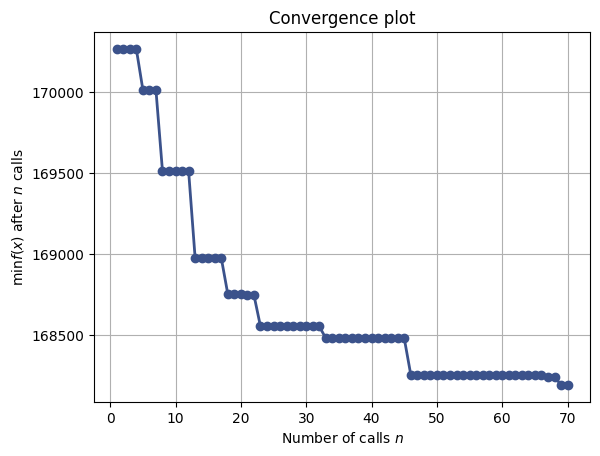

In [63]:
from skopt.plots import plot_objective, plot_histogram, plot_convergence
# Podemos comprobar si la optimización ha convergido
_ = plot_convergence(regr_tree_hpo_bayes.optimizer_results_[0])
plt.show()

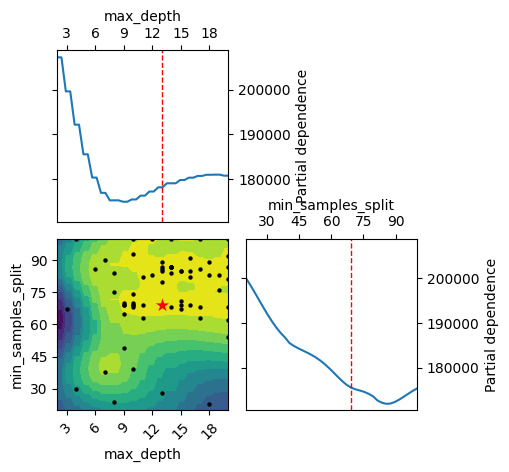

<Figure size 4000x1500 with 0 Axes>

In [64]:
_ = plot_objective(regr_tree_hpo_bayes.optimizer_results_[0],
                   dimensions=['max_depth', 'min_samples_split'],
                   n_minimum_search=int(1e8))
plt.figure(figsize=(40, 15)) 
plt.show()

In [65]:
y_test_pred = regr_tree_hpo_bayes.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo_bayes = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo_bayes = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo_bayes}")
print(f"R2 of the tree: {r2_tree_hpo_bayes}")
print(f"Mejores parámetros: {regr_tree_hpo_bayes.best_params_}")

RMSE of the tree: 421.7351794651437
R2 of the tree: 0.5872155934729344
Mejores parámetros: OrderedDict([('max_depth', 13), ('min_samples_split', 69)])


Como podemos ver, el rendimiento con este modelo tampoco mejora mucho. Podríamos aumentar el número de iteraciones que realizará la busqueda de hiperparámetros e intentar conseguir que mejore el rendimiento del modelo. Sin embargo, como podemos ver en la gráfica de convergencia,  el valor de la métrica tras cierto número de iteraciones muestra poco cambio. Por este motivo, esta idea se descarta, ya que no obtenedremos beneficios significatos. Además, otro motivo también es por el tiempo de ejecución, que aumentaría innecesariamente.

### Regularización Ridge.

Ahora pasaremos a evaluar el rendimiento del modelo con regularización Ridge. Esta técnica utiliza el parametro *alpha* para imponer una penalización en los coeficientes del modelo. 

In [66]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_ridge_hpo = GridSearchCV(Ridge(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_ridge_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_ridge_hpo = fin - inicio

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [67]:
y_test_pred = regr_ridge_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge_hpo}")
print(f"R2: {r2_ridge_hpo}")
print(f"Mejor parámetro: {regr_ridge_hpo.best_params_}")

RMSE: 539.8413921387786
R2: 0.32364300592376694
Mejor parámetro: {'alpha': 0.3}


### Regularización Lasso.

Por otro lado, evaluaremos el modelo de regresión lineal con regularización Lasso. Al igual que Ridge, también se trata de una técnica que impone una penalización en los coeficientes del modelo, con una pequeña diferencia del anterior, que puede forza a que algunos coeficientes sean cero.

In [68]:
param_grid = {'alpha': [0, 0.001, 0.005, 0.01]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_lasso_hpo = GridSearchCV(Lasso(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_lasso_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_lasso_hpo = fin - inicio

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/celia/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/celia/min

In [69]:
y_test_pred = regr_lasso_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_lasso_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lasso_hpo}")
print(f"R2: {r2_lasso_hpo}")
print(f"Mejor parámetro: {regr_lasso_hpo.best_params_}")

RMSE: 539.6890229836447
R2: 0.3240247528649597
Mejor parámetro: {'alpha': 0}


Al realizar la regularización Lasso, el mejor parámetro para alpha es 0. Esto significa que es mejor utilizar un modelo estándar de regresión lineal sin regularización Lasso.

### Regresión lineal

Este modelo es interesante evaluarlo debido a que al realizar el ajuste por hiperparámetros del modelo de regularización Lasso, hemos obtenido que el mejor valor para *alpha* era 0. 

### SVM lineal

Como siguiente modelo a evaluar se trata del SVM lineal. Es decir, con el kernel especificado a lineal. Tras el ajuste de su hiperparámetro, hemos obtenido lo siguiente.

In [70]:
param_grid = {'C': [5000, 10000, 15000, 20000, 25000, 30000]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_lineal_hpo = GridSearchCV(SVR(kernel="linear"),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_lineal_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_lineal_hpo = fin - inicio

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [71]:
y_test_pred = regr_svm_lineal_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_lineal_hpo}")
print(f"R2: {r2_svm_lineal_hpo}")
print(f"Mejor parámetro: {regr_svm_lineal_hpo.best_params_}")

RMSE: 572.6160468720577
R2: 0.2390245388708796
Mejor parámetro: {'C': 10000}


### SVM Radial

El siguiente modelo a evaluar, va a ser el mismo que el anterior, pero el radial. Es decir, el kernel dado por omisión, el radial. Tras el ajuste de hiperparámetros, obtenemos lo siguiente.

In [72]:
param_grid = {'C': [10000, 20000, 30000, 40000, 50000],
              'gamma': [0.001, 0.01, 0.05, 0.1]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_radial_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_radial_hpo = fin - inicio

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [73]:
y_test_pred = regr_svm_radial_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial_hpo}")
print(f"R2: {r2_svm_radial_hpo}")
print(f"Mejor parámetro: {regr_svm_radial_hpo.best_params_}")

RMSE: 360.09464936043696
R2: 0.6990620486945289
Mejor parámetro: {'C': 30000, 'gamma': 0.01}


Con este modelo, tras el proceso de ajustar ambos parámetros, obtenemos que una notable mejora en la predicción. Tras la evaluación del modelo, podemos ver como se reduce bastante el valor del RMSE y como aumenta en gran medida el R2, respecto al modelo dummy, al SVM radial con los datos por omisión y al SVM lineal por ajuste de hiperparámetros.

---
## Tiempos de entrenamiento
---

En esta sección expondremos y analizaremos los tiempos de ejecución junto a los resultados obtenidos de cada modelo para evaluar el rendimiento de cada uno de ellos. Con el fin principal de obtener conclusiones acerca de este problema de regresión.

In [96]:
# Tomaremos como referencia el modelo Dummy.
tabla_dummy = pd.DataFrame({
    "Modelo": ["Dummy"],
    "RMSE": [rmse_dummy],
    "R2": [r2_dummy],
    "Tiempo": [t_dummy]
})

tabla_dummy

,Modelo,RMSE,R2,Tiempo
0,Dummy,692.091301,-0.111656,0.000873


In [118]:
# Resultados por defecto
resultados_default = pd.DataFrame({
    "RMSE": [rmse_knn_scaled, rmse_lineal, rmse_tree, rmse_ridge, rmse_lasso, rmse_svm_lineal, rmse_svm_radial],
    "R2": [r2_knn_scaled, r2_lineal, r2_tree, r2_ridge, r2_lasso, r2_svm_lineal, r2_svm_radial],
    "Tiempo": [t_knn, t_lineal, t_tree, t_ridge, t_lasso, t_svm_lineal, t_svm_radial]
})

# Resultados con optimización de hiperparámetros
resultados_hpo = pd.DataFrame({
    "RMSE (HPO)": [rmse_knn_hpo, 0, rmse_tree_hpo, rmse_ridge_hpo, rmse_lasso_hpo, rmse_svm_lineal_hpo, rmse_svm_radial_hpo],
    "R2 (HPO)": [r2_knn_hpo, 0, r2_tree_hpo, r2_ridge_hpo, r2_lasso_hpo, r2_svm_lineal_hpo, r2_svm_radial_hpo],
    "Tiempo (HPO)": [t_knn_hpo, 0, t_tree_hpo, t_ridge_hpo, t_lasso_hpo, t_svm_lineal_hpo, t_svm_radial_hpo]
})

# Fusionamos los datos de las dos tablas
resultados = pd.concat([resultados_default, resultados_hpo], axis=1)
resultados.index = ["KNN", "Regresión Lineal", "Árbol de decisión", "Ridge", "Lasso", "SVM lineal", "SVM radial"]
resultados

,RMSE,R2,Tiempo,RMSE (HPO),R2 (HPO),Tiempo (HPO)
KNN,402.269009,0.624442,0.000844,398.145327,0.632102,0.959705
Regresión Lineal,539.761203,0.323844,0.008529,0.000000,0.000000,0.000000
Árbol de decisión,509.815211,0.396789,0.086788,423.624316,0.583509,1.686757
Ridge,540.100085,0.322995,0.002085,539.841392,0.323643,0.052294
Lasso,540.100085,0.322995,0.002344,539.689023,0.324025,0.235337
SVM lineal,587.146049,0.199915,0.196943,572.616047,0.239025,67.102949
SVM radial,632.107878,0.072688,0.237860,360.094649,0.699062,27.161238


In [121]:
# Añadimos los resultados del árbol de decisión modelo.
tabla = pd.DataFrame({
    "RMSE": [rmse_linear_tree, rmse_tree_hpo_bayes],
    "R2": [r2_linear_tree, r2_tree_hpo_bayes],
    "Tiempo": [t_linear_tree, t_tree_hpo_bayes]
}, index=["Árbol de decisión modelo", "Árbol de decisión HPO Bayes"])
tabla


,RMSE,R2,Tiempo
Árbol de decisión modelo,383.133115,0.659323,169.214923
Árbol de decisión HPO Bayes,421.735179,0.587216,117.975460
